# Hurricane Classification using Ensembling Techniques 
      - Group Members :
      - Reiyo 
      - Kanchan Maurya 

In [ ]:
# Importing necessary Libraries
import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import cv2
from pathlib import Path
from PIL import Image
import os
from zipfile import ZipFile
import shutil
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torchvision import models
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import RandomSampler



In [ ]:
# Installing Yolov5
!pip install yolov5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzipping the folder 
#Ran only once for dataset creation
file_name = "/content/drive/MyDrive/NASA_DATASET/Images.zip"
output_folder = "/content/drive/MyDrive/NASA_DATASET/extracted_images"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with ZipFile(file_name, 'r') as zip:
    for file in zip.namelist():
        if file.endswith('.jpg') or file.endswith('.png'):
            zip.extract(file, output_folder)

print('Extraction complete.')

Extraction complete.


In [ ]:
# Detection of spirals for labelling
def _box_cxcywh_to_xyxy(boxes):
    print(f"Input tensor shape: {boxes.shape}")
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), dim=-1)

# Example usage
boxes = torch.tensor([[0.1, 0.2, 0.3, 0.4]])
output = _box_cxcywh_to_xyxy(boxes)
print(f"Output tensor shape: {output.shape}")


Input tensor shape: torch.Size([1, 4])
Output tensor shape: torch.Size([1, 4])


In [ ]:
# Unsing Yolo V5 to label the images and store it into the location
# Load the YOLOv5 model

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Define the input directory path
input_dir = Path('/content/drive/MyDrive/Images/Images')

# Define the output directory paths for hurricane and no hurricane images
hurricane_dir = Path('/content/drive/MyDrive/Images/Hurricane')
no_hurricane_dir = Path('/content/drive/MyDrive/Images/No_Hurricane')

# Detection threshold for the YOLOv5 model
detection_threshold = 0.2

# Loop through all images in the input directory
for img_path in input_dir.glob('*.jpg'):
    try:
        # Open the image and convert to a numpy array
        img = np.array(Image.open(img_path))

        # Detect the spiral shape using YOLOv5 model
        results = model(img, conf=detection_threshold)

        # Extract the bounding boxes of the detected objects
        bboxes = results.xyxy[0].cpu().numpy()

        # Filter the bounding boxes to only include the spiral shape
        spiral_bboxes = bboxes[bboxes[:, 5] == 0] # Adjust the class index if needed

        # If the image contains a spiral shape, move it to the hurricane folder
        if len(spiral_bboxes) > 0:
            img_name = img_path.name
            output_path = hurricane_dir / img_name
            img_path.replace(output_path)

        # If the image does not contain a spiral shape, move it to the no hurricane folder
        else:
            img_name = img_path.name
            output_path = no_hurricane_dir / img_name
            img_path.replace(output_path)

    except OSError:
        print(f"Skipping file: {img_path}")

print('Processing complete.')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-12 Python-3.10.11 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Processing complete.


YOLO V5 Detecting the Spirals in the images and Labelling the dataset

In [ ]:

#folder_path = '/content/drive/MyDrive/Images/No_Hurricane'

# Delete the folder
#shutil.rmtree(folder_path)

In [ ]:
#Data Augmentation to tacle class imabalance

# Define data augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply data augmentation to the hurricane images
hurricane_images = list(Path('/content/drive/MyDrive/Images/Hurricane').glob('*.jpg'))
augmented_hurricane_images = []

for image_path in hurricane_images:
    image = Image.open(image_path)
    augmented_image = augmentation_transforms(image)
    augmented_hurricane_images.append(augmented_image)

# Save the augmented hurricane images to a new directory
augmented_hurricane_dir = Path('/content/drive/MyDrive/Images/Hurricane')
augmented_hurricane_dir.mkdir(exist_ok=True)

for i, image in enumerate(augmented_hurricane_images):
    image_path = augmented_hurricane_dir / f"hurricane_{i}.jpg"
    torchvision.utils.save_image(image, image_path)


In [ ]:
#Random Sampling 

# Load the hurricane and no hurricane images
hurricane_images = list(Path('/content/drive/MyDrive/Images/Hurricane').glob('*.jpg'))
no_hurricane_images = list(Path('/content/drive/MyDrive/Images/No_Hurricane').glob('*.jpg'))

# Define the number of samples to balance the classes
num_samples = min(len(hurricane_images), len(no_hurricane_images))

# Randomly sample a subset of hurricane images
hurricane_sampler = RandomSampler(range(len(hurricane_images)), replacement=False, num_samples=num_samples)
balanced_hurricane_indices = list(hurricane_sampler)
balanced_hurricane_images = [hurricane_images[i] for i in balanced_hurricane_indices]

# Randomly sample a subset of no hurricane images
no_hurricane_sampler = RandomSampler(range(len(no_hurricane_images)), replacement=False, num_samples=num_samples)
balanced_no_hurricane_indices = list(no_hurricane_sampler)
balanced_no_hurricane_images = [no_hurricane_images[i] for i in balanced_no_hurricane_indices]

# Move the balanced images to new directories
balanced_hurricane_dir = Path('/content/drive/MyDrive/output/train/Hurricane')
balanced_no_hurricane_dir = Path('/content/drive/MyDrive/output/train/No_Hurricane')

balanced_hurricane_dir.mkdir(exist_ok=True)
balanced_no_hurricane_dir.mkdir(exist_ok=True)

for i, image_path in enumerate(balanced_hurricane_images):
    image_name = f"hurricane_{i}.jpg"
    output_path = balanced_hurricane_dir / image_name
    image_path.rename(output_path)

for i, image_path in enumerate(balanced_no_hurricane_images):
    image_name = f"no_hurricane_{i}.jpg"
    output_path = balanced_no_hurricane_dir / image_name
    image_path.rename(output_path)


The Above two blocks were used to perform Data Augmentation on the Dataset to treat class imbalances in the dataset.

In [ ]:
/content/drive/MyDrive/Images/Hurricane

In [ ]:
# Making train and test folder to store train and test data 
# Only ran once. 

# Set up input and output directories
input_dir_hurricane = '/content/drive/MyDrive/Images/Hurricane'
input_dir_no_hurricane = '/content/drive/MyDrive/Images/No_Hurricane'
output_dir = '/content/drive/MyDrive/output_6'

# Split the dataset into training and validation sets
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'test')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the proportion of images to use for validation
val_split = 0.3

# Loop over the classes in the dataset
for class_dir in [input_dir_hurricane, input_dir_no_hurricane]:

    # Get the list of image file names in this class
    image_files = list(Path(class_dir).glob('*.jpg'))

    # Split the image files into training and validation sets
    train_files, val_files = train_test_split(image_files, test_size=val_split, random_state=42)

    # Copy the training files to the output directory
    class_name = os.path.basename(class_dir)
    train_class_dir = os.path.join(train_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    for f in train_files:
        src_path = str(f)
        dst_path = os.path.join(train_class_dir, os.path.basename(f))
        shutil.copy(src_path, dst_path)

    # Copy the validation files to the output directory
    val_class_dir = os.path.join(val_dir, class_name)
    if not os.path.exists(val_class_dir):
        os.makedirs(val_class_dir)
    for f in val_files:
        src_path = str(f)
        dst_path = os.path.join(val_class_dir, os.path.basename(f))
        shutil.copy(src_path, dst_path)

We created train and test folders in our work directory to store 70% of the data into train folder and the remaining to the test folder

In [ ]:
# Data Transforms and Data Loader for storing Training and Testing image batches.

def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to 256x256 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image
        transforms.CenterCrop(252)  # Crop a 2 cm border from each side (256 - 2*2 = 252)
    ])
    return transform

train_data_folder = "/content/drive/MyDrive/output_F/train"
test_data_folder = "/content/drive/MyDrive/output_F/test"

# Define the transforms
transform = get_transforms()

# Create the datasets
train_dataset = ImageFolder(train_data_folder, transform=transform)
test_dataset = ImageFolder(test_data_folder, transform=transform)

# Create the dataloaders
batch_size = 32  # Set the desired batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


We created a data loader for the train and the test data.

In [ ]:
# function for Plotting 

def imshow(image):
    """
    Display the given image.

    Args:
        image (torch.Tensor): Image tensor.

    Returns:
        None
    """
    # Convert the tensor to a NumPy array and permute dimensions
    np_image = image.permute(1, 2, 0).numpy()

    # Unnormalize the image by scaling and shifting
    np_image = np_image * 0.5 + 0.5

    # Display the image
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


First random image from the train data loader:


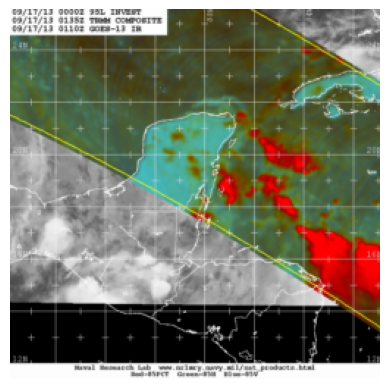

Class: No_Hurricane
Second random image from the train data loader:


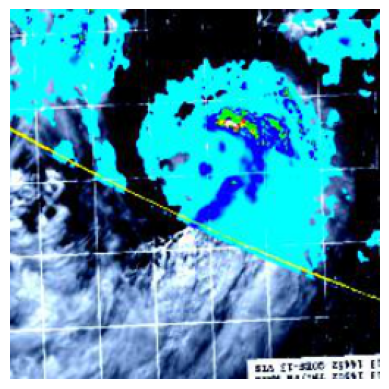

Class: Hurricane
First random image from the test data loader:


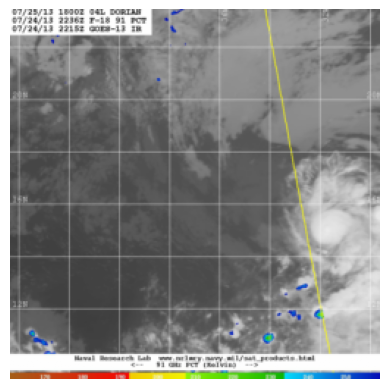

Class: Hurricane
Second random image from the test data loader:


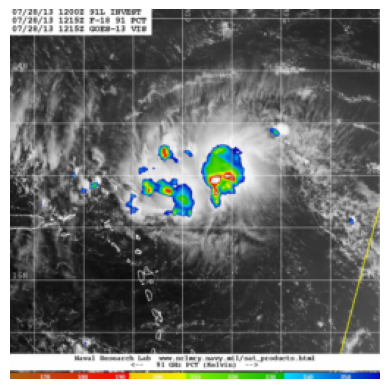

Class: Hurricane


In [ ]:
# Plotting Random Images from Train and Test Loader 

# Get random indices for two images from the train data loader
train_indices = random.sample(range(len(train_dataset)), 2)
train_image1, train_label1 = train_dataset[train_indices[0]]
train_image2, train_label2 = train_dataset[train_indices[1]]

# Display the first random image from the train data loader
print("First random image from the train data loader:")
imshow(train_image1)
print("Class:", train_dataset.classes[train_label1])

# Display the second random image from the train data loader
print("Second random image from the train data loader:")
imshow(train_image2)
print("Class:", train_dataset.classes[train_label2])

# Get random indices for two images from the test data loader
test_indices = random.sample(range(len(test_dataset)), 2)
test_image1, test_label1 = test_dataset[test_indices[0]]
test_image2, test_label2 = test_dataset[test_indices[1]]

# Display the first random image from the test data loader
print("First random image from the test data loader:")
imshow(test_image1)
print("Class:", test_dataset.classes[test_label1])

# Display the second random image from the test data loader
print("Second random image from the test data loader:")
imshow(test_image2)
print("Class:", test_dataset.classes[test_label2])


We can see the classified Images above. The YOLO V5 accurately detected the images with spirals and labelled them as hurracne and if there were no spirals it labelled them as No_Hurricane

In [ ]:
# Handcrafted CNN with Residual Blocks 
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class CovNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CovNet, self).__init__()

        self.in_channels = 64

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.layer5 = self._make_layer(1024, 2, stride=2)
        self.layer6 = self._make_layer(2048, 2, stride=2)

        # Fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.fc2(out)
        return out




The above is the architecture that we used for our handcrafted model. It is explained well in our research paper

In [ ]:
# Training Function
def train_model(model, train_dataloader, criterion, optimizer, num_epochs):
    """
    Trains the model on the given train_dataloader for the specified number of epochs.

    Args:
        model (torch.nn.Module): The model to train.
        train_dataloader (torch.utils.data.DataLoader): The training dataloader.
        criterion: The loss criterion.
        optimizer: The optimizer for model parameter updates.
        num_epochs (int): The number of training epochs.

    Returns:
        torch.nn.Module: The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_predictions += torch.sum(predictions == labels).item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = correct_predictions / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Print training progress for each epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

    # Plotting accuracy and loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 - Loss: 0.6644 - Accuracy: 0.6243
Epoch 2/10 - Loss: 0.5465 - Accuracy: 0.6791
Epoch 3/10 - Loss: 0.5275 - Accuracy: 0.6952
Epoch 4/10 - Loss: 0.5274 - Accuracy: 0.6840
Epoch 5/10 - Loss: 0.4996 - Accuracy: 0.7296
Epoch 6/10 - Loss: 0.4961 - Accuracy: 0.7310
Epoch 7/10 - Loss: 0.4858 - Accuracy: 0.7430
Epoch 8/10 - Loss: 0.4746 - Accuracy: 0.7500
Epoch 9/10 - Loss: 0.4739 - Accuracy: 0.7388
Epoch 10/10 - Loss: 0.4688 - Accuracy: 0.7416


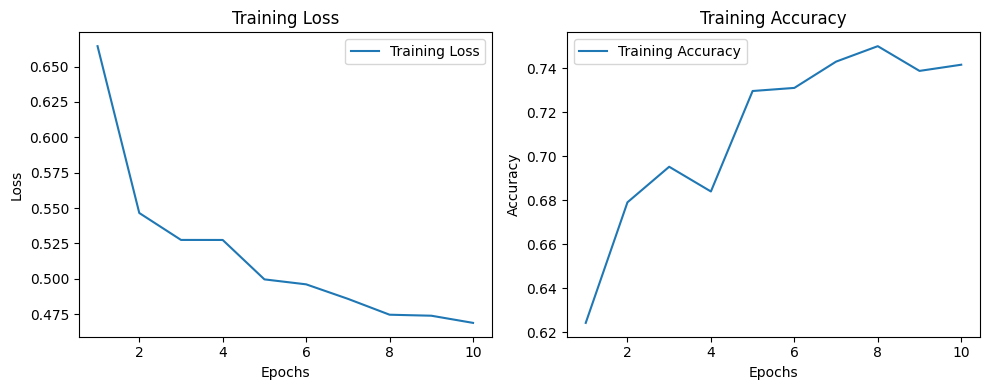

In [ ]:
# Training the Hand Crafted Model

input_channels = 3
num_classes = 2
num_epochs = 10
learning_rate = 0.001


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CovNet()

# Define the optimizer and the criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
trained_model = train_model(model, train_dataloader, criterion, optimizer, num_epochs)

# Save the trained ResNet50 model
torch.save(model.state_dict(), "CovNet.pth")


The Hand Crafted Model has a training Accuracy of 74.16%

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 386MB/s]


Epoch 1/10 - Loss: 0.5728 - Accuracy: 0.6917
Epoch 2/10 - Loss: 0.4989 - Accuracy: 0.7296
Epoch 3/10 - Loss: 0.4721 - Accuracy: 0.7423
Epoch 4/10 - Loss: 0.4690 - Accuracy: 0.7633
Epoch 5/10 - Loss: 0.4460 - Accuracy: 0.7683
Epoch 6/10 - Loss: 0.4239 - Accuracy: 0.7739
Epoch 7/10 - Loss: 0.4320 - Accuracy: 0.7697
Epoch 8/10 - Loss: 0.3973 - Accuracy: 0.8083
Epoch 9/10 - Loss: 0.3922 - Accuracy: 0.7999
Epoch 10/10 - Loss: 0.4086 - Accuracy: 0.7978


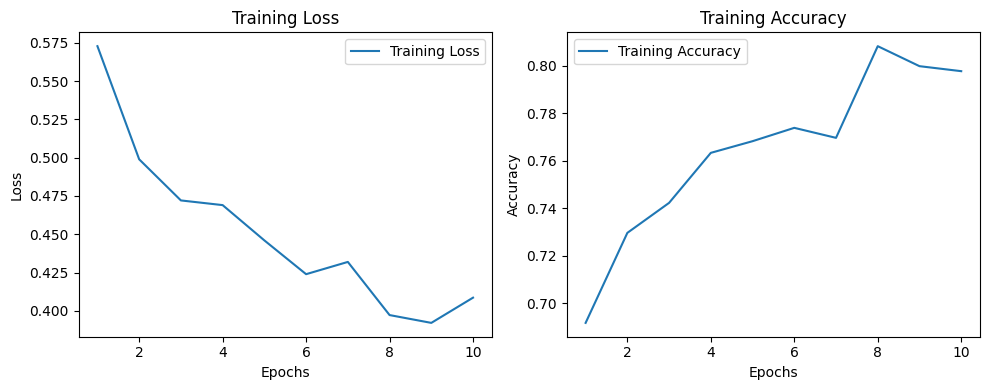

In [ ]:
# Training the resnet50 model

# Set the device based on the availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.to(device)

# Define the optimizer and loss criterion
resnet50_optimizer = optim.Adam(resnet50.parameters(), lr=learning_rate)
resnet50_criterion = nn.CrossEntropyLoss()

# Train the ResNet50 model
resnet50 = train_model(resnet50, train_dataloader, resnet50_criterion, resnet50_optimizer, num_epochs)

# Save the trained ResNet50 model
torch.save(resnet50.state_dict(), "resnet50_model.pth")


The ResNet50 has a training Accuracy of 79.78%

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:04<00:00, 44.6MB/s]


Epoch 1/10 - Loss: 0.5767 - Accuracy: 0.6959
Epoch 2/10 - Loss: 0.5170 - Accuracy: 0.6994
Epoch 3/10 - Loss: 0.4849 - Accuracy: 0.7254
Epoch 4/10 - Loss: 0.4917 - Accuracy: 0.7233
Epoch 5/10 - Loss: 0.4549 - Accuracy: 0.7563
Epoch 6/10 - Loss: 0.4789 - Accuracy: 0.7542
Epoch 7/10 - Loss: 0.4503 - Accuracy: 0.7683
Epoch 8/10 - Loss: 0.4476 - Accuracy: 0.7795
Epoch 9/10 - Loss: 0.4260 - Accuracy: 0.7781
Epoch 10/10 - Loss: 0.4249 - Accuracy: 0.7886


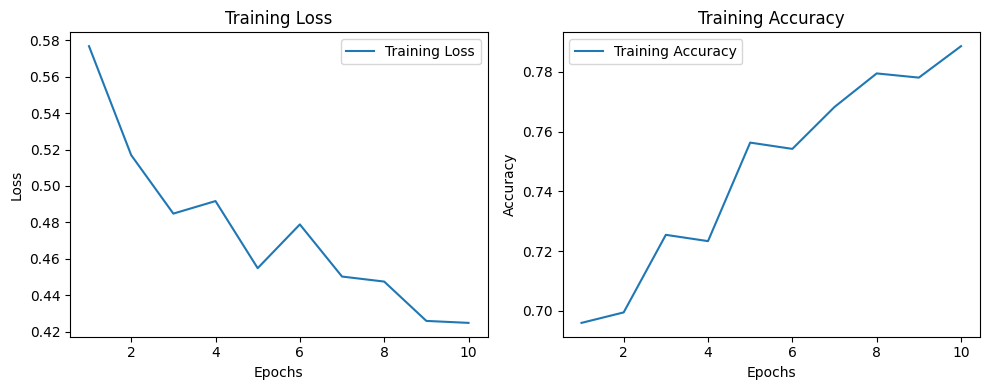

In [ ]:
# Training the resnet101 model

# Set the device based on the availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet101 model
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Linear(resnet101.fc.in_features, num_classes)
resnet101.to(device)

# Define the optimizer and loss criterion
resnet101_optimizer = optim.Adam(resnet101.parameters(), lr=learning_rate)
resnet101_criterion = nn.CrossEntropyLoss()

# Train the ResNet101 model
resnet101 = train_model(resnet101, train_dataloader, resnet101_criterion, resnet101_optimizer, num_epochs)

# Save the trained ResNet101 model
torch.save(resnet101.state_dict(), "resnet101_model.pth")


The ResNet101 has a training Accuracy of 78.86%

In [ ]:
# Installing efficientnet
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=bd15b83947a9f7e9b5fd52e2db6e83b613bfaf9364c769306b670d16dbafe62f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# Updating torchvision
!pip install --upgrade torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
# Train the EfficientNet model
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=learning_rate)

# Custom Training 
for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_predictions += torch.sum(predictions == labels).item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / len(train_dataloader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

# Save the trained EfficientNet model
torch.save(efficientnet.state_dict(), "efficientnet_model.pth")


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 59.2MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch 1/10 - Loss: 0.4770 - Accuracy: 0.7570
Epoch 2/10 - Loss: 0.3737 - Accuracy: 0.8272
Epoch 3/10 - Loss: 0.3556 - Accuracy: 0.8399
Epoch 4/10 - Loss: 0.2722 - Accuracy: 0.8926
Epoch 5/10 - Loss: 0.2157 - Accuracy: 0.9087
Epoch 6/10 - Loss: 0.2078 - Accuracy: 0.9199
Epoch 7/10 - Loss: 0.1539 - Accuracy: 0.9424
Epoch 8/10 - Loss: 0.1366 - Accuracy: 0.9494
Epoch 9/10 - Loss: 0.1145 - Accuracy: 0.9600
Epoch 10/10 - Loss: 0.0871 - Accuracy: 0.9684


The EfficientNet has a training Accuracy of 96.84%

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 60.8MB/s]


Epoch 1/10 - Loss: 0.4885 - Accuracy: 0.7458
Epoch 2/10 - Loss: 0.4192 - Accuracy: 0.7935
Epoch 3/10 - Loss: 0.4102 - Accuracy: 0.7942
Epoch 4/10 - Loss: 0.3486 - Accuracy: 0.8399
Epoch 5/10 - Loss: 0.3143 - Accuracy: 0.8567
Epoch 6/10 - Loss: 0.2849 - Accuracy: 0.8785
Epoch 7/10 - Loss: 0.3145 - Accuracy: 0.8666
Epoch 8/10 - Loss: 0.2244 - Accuracy: 0.9150
Epoch 9/10 - Loss: 0.1862 - Accuracy: 0.9354
Epoch 10/10 - Loss: 0.2010 - Accuracy: 0.9206


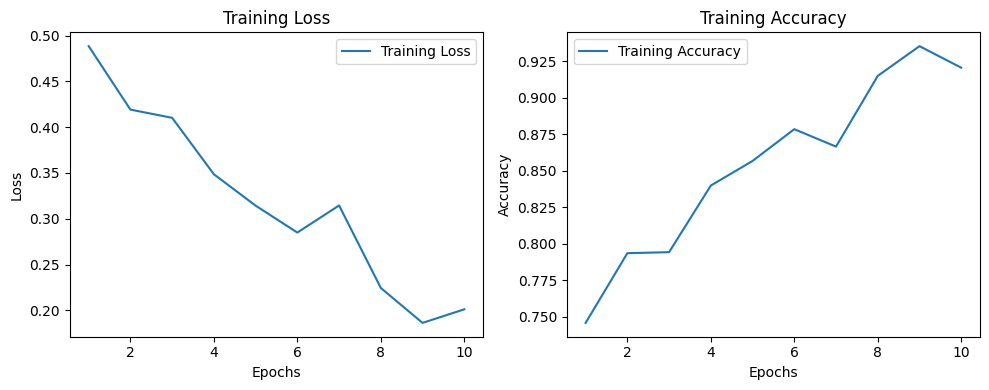

In [ ]:
# Train the GoogLeNet model
googlenet = models.googlenet(pretrained=True)
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)
googlenet.to(device)

# Define the optimizer and loss criterion
googlenet_optimizer = optim.Adam(googlenet.parameters(), lr=learning_rate)
googlenet_criterion = nn.CrossEntropyLoss()

# Train the GoogLeNet model
googlenet = train_model(googlenet, train_dataloader, googlenet_criterion, googlenet_optimizer, num_epochs)

# Save the trained GoogLeNet model
torch.save(googlenet.state_dict(), "googlenet_model.pth")


The ResNet50 has a training Accuracy of 92.06%

In [ ]:
# Testing Function + Ensembling using majority voting 
 
def ensemble_test(models, dataloader):
    """
    Performs testing and evaluation of an ensemble of models on a given dataloader.

    Args:
        models (list): List of models to be evaluated as an ensemble.
        dataloader (torch.utils.data.DataLoader): Dataloader for test dataset.

    Returns:
        list: Ensemble predictions for the test dataset.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move models to device and set to evaluation mode
    for model in models:
        model.to(device)
        model.eval()

    correct_predictions = 0
    ensemble_predictions = []

    model_names = ['ResNet50', 'ResNet101', 'EfficientNet', 'GoogLeNet','CovNet']
    accuracy_scores = []
    loss_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = []
            for model in models:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.append(preds)

            # Perform majority voting to get ensemble predictions
            ensemble_preds = torch.mode(torch.stack(predictions), dim=0).values
            ensemble_predictions.extend(ensemble_preds.cpu().tolist())

            correct_predictions += torch.sum(ensemble_preds == labels).item()

    accuracy = correct_predictions / len(dataloader.dataset)
    print("Ensemble Statistics:")
    print(f"Accuracy: {accuracy:.4f}")

    # Compute accuracy and loss for each model
    for i, model in enumerate(models):
        model.to(device)
        model.eval()

        model_preds = []
        model_losses = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                model_preds.extend(preds.cpu().tolist())
                model_losses.append(loss.item())

        model_accuracy = accuracy_score(dataloader.dataset.targets, model_preds)
        accuracy_scores.append(model_accuracy)
        loss_scores.append(model_losses)

        print(f"\nModel: {model_names[i]}")
        print(f"Accuracy: {model_accuracy:.4f}")

    # Plot accuracy and loss for each model
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.bar(model_names, accuracy_scores)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')

    # Loss plot
    plt.subplot(1, 2, 2)
    for i in range(len(models)):
        plt.plot(loss_scores[i], label=model_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return ensemble_predictions


Loaded pretrained weights for efficientnet-b0
Ensemble Statistics:
Accuracy: 0.8068

Model: ResNet50
Accuracy: 0.7917

Model: ResNet101
Accuracy: 0.7670

Model: EfficientNet
Accuracy: 0.8769

Model: GoogLeNet
Accuracy: 0.8409

Model: CovNet
Accuracy: 0.7538


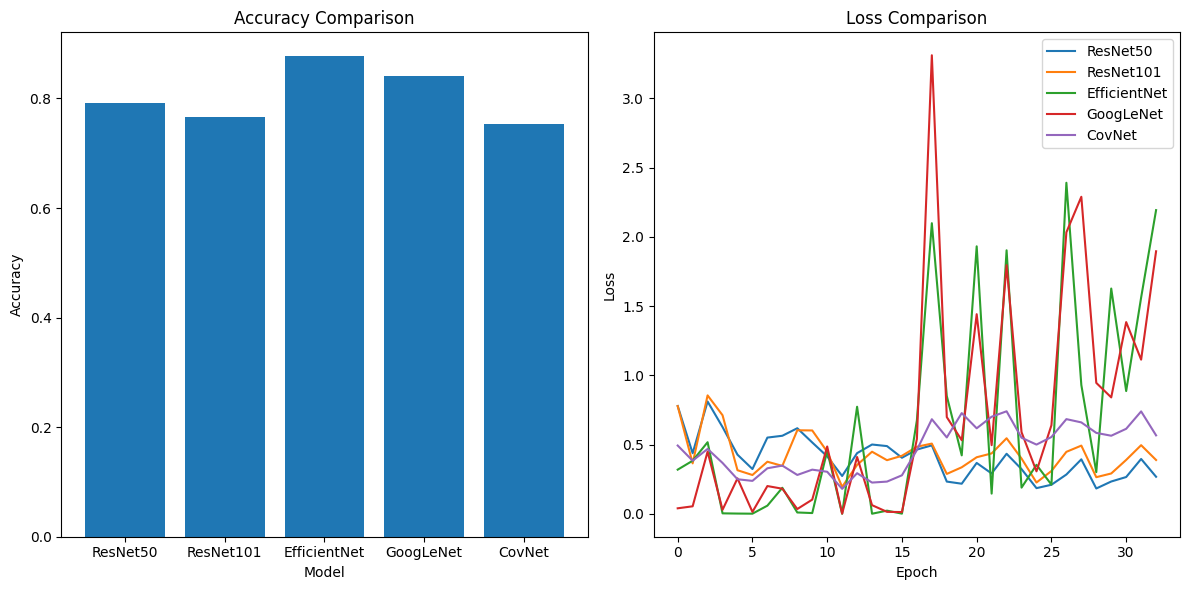

In [ ]:
#Evaluating the ensemble model 

# Load the trained ResNet50 model
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.load_state_dict(torch.load("/content/resnet50_model.pth"))

# Load the trained ResNet101 model
resnet101 = models.resnet101(pretrained=False)
resnet101.fc = nn.Linear(resnet101.fc.in_features, num_classes)
resnet101.load_state_dict(torch.load("/content/resnet101_model.pth"))

# Load the trained EfficientNet model
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(num_ftrs, num_classes)
efficientnet.load_state_dict(torch.load("/content/efficientnet_model.pth"))

# Load the trained GoogLeNet model
googlenet = models.googlenet(pretrained=False)
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)

# Load the GoogLeNet state dictionary with strict=False
state_dict = torch.load("/content/googlenet_model.pth")
googlenet.load_state_dict(state_dict, strict=False)

# Load the "CovNet" model
input_channels = 3
num_classes = 2
model = CovNet()
model.load_state_dict(torch.load("CovNet.pth"))

# Create a list of models
models = [resnet50, resnet101, efficientnet, googlenet, model]

# Evaluate the test loader using ensemble voting
ensemble_predictions = ensemble_test(models, test_dataloader)


The Final Ensemble model has an Accuracy of 80.68%

# Research Paper Link 

https://www.researchgate.net/publication/370729188_Hurricane_Classification_using_Ensemble_Techniques

# Model .pth google Drive Link 

https://drive.google.com/file/d/16EbHEgZnGXclhv76a4a1eSwkL5AqRlBU/view?usp=share_link

The above link has the model .pth zip file .The Zip File contains the 5 .pth files for the 5 models 